In [1]:
# import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import sklearn.metrics as metrics
from sklearn.svm import LinearSVC

# for over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

import re
import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
dataset = pd.read_csv('reviews.csv')
dataset.head()

,Id,Review,Score
0,0,good and interesting,5
1,1,"This class is very helpful to me. Currently, I...",5
2,2,like!Prof and TAs are helpful and the discussi...,5
3,3,Easy to follow and includes a lot basic and im...,5
4,4,Really nice teacher!I could got the point eazl...,4


In [3]:
def polarity_to_label(x):
    
  if x == 5:
    return 'Very Positive'
  elif x == 4:
    return 'Positive'
  elif x == 3:
    return 'Neutral'
  elif x == 2:
    return 'Negative'
  elif x == 1:
    return 'Very Negative'


dataset['Score'] = dataset['Score'].apply(polarity_to_label)
dataset.head()

,Id,Review,Score
0,0,good and interesting,Very Positive
1,1,"This class is very helpful to me. Currently, I...",Very Positive
2,2,like!Prof and TAs are helpful and the discussi...,Very Positive
3,3,Easy to follow and includes a lot basic and im...,Very Positive
4,4,Really nice teacher!I could got the point eazl...,Positive


In [4]:
dataset['Score'].value_counts()

Very Positive    79173
Positive         18054
Neutral           5071
Very Negative     2469
Negative          2251
Name: Score, dtype: int64

<AxesSubplot:ylabel='Score'>

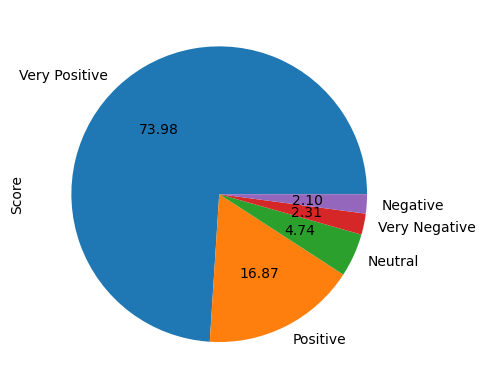

In [5]:
dataset['Score'].value_counts().plot.pie(autopct='%.2f')

# Dataset Processing

In [6]:

lemma = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def CleanReview(txt):
    txt = txt.lower()
    txt = re.sub(r'([@#][\w-]+)|http\S+|rt[\s]+|(\\\\u([a-z]|[0-9])+)|[0-9]|[^a-zA-Z0-9 \n]', '', txt)
    txt = word_tokenize(txt)
    txt = [item for item in txt if item not in stop_words]
    
    txt = [lemma.lemmatize(word=w, pos='v') for w in txt]
    txt = [i for i in txt if len(i) > 2]
    txt = ' '. join(txt)
    return txt

dataset['CleanedReview'] = dataset['Review'].apply(CleanReview)
dataset.head()

,Id,Review,Score,CleanedReview
0,0,good and interesting,Very Positive,good interest
1,1,"This class is very helpful to me. Currently, I...",Very Positive,class helpful currently still learn class make...
2,2,like!Prof and TAs are helpful and the discussi...,Very Positive,likeprof tas helpful discussion among students...
3,3,Easy to follow and includes a lot basic and im...,Very Positive,easy follow include lot basic important techni...
4,4,Really nice teacher!I could got the point eazl...,Positive,really nice teacheri could get point eazliy


In [7]:
dfc = dataset.drop(['Review'], axis = 1)
dfc.head()

,Id,Score,CleanedReview
0,0,Very Positive,good interest
1,1,Very Positive,class helpful currently still learn class make...
2,2,Very Positive,likeprof tas helpful discussion among students...
3,3,Very Positive,easy follow include lot basic important techni...
4,4,Positive,really nice teacheri could get point eazliy


In [8]:
X = dfc['CleanedReview']
y = dfc['Score']

In [9]:
X

0                                             good interest
1         class helpful currently still learn class make...
2         likeprof tas helpful discussion among students...
3         easy follow include lot basic important techni...
4               really nice teacheri could get point eazliy
                                ...                        
107013    trendy topic talk expertises field cover areas...
107014    wonderful simple clear language good instructo...
107015                     interest fun course thank quincy
107016    broad perspective date information useful link...
107017    informative course social financial implicatio...
Name: CleanedReview, Length: 107018, dtype: object

In [10]:
y.value_counts()

Very Positive    79173
Positive         18054
Neutral           5071
Very Negative     2469
Negative          2251
Name: Score, dtype: int64

# Vectorize Text data

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)

# Spliting the processed dataset

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

In [13]:
X_train

<85614x44802 sparse matrix of type '<class 'numpy.float64'>'
	with 1021675 stored elements in Compressed Sparse Row format>

In [14]:
y_train.value_counts()

Very Positive    63315
Positive         14451
Neutral           4057
Very Negative     1967
Negative          1824
Name: Score, dtype: int64

# Train and Test Model

In [15]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, y_train)

y_preds = clf.predict(X_test)

# Classification report
print(classification_report(y_test, y_preds))
print("Accuracy:", metrics.accuracy_score(y_test, y_preds))

               precision    recall  f1-score   support

     Negative       0.33      0.10      0.16       427
      Neutral       0.32      0.10      0.16      1014
     Positive       0.45      0.24      0.31      3603
Very Negative       0.54      0.38      0.45       502
Very Positive       0.82      0.96      0.88     15858

     accuracy                           0.77     21404
    macro avg       0.49      0.36      0.39     21404
 weighted avg       0.72      0.77      0.73     21404

Accuracy: 0.7691085778359186


# Simplify Steps using Pipeline

In [16]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('linear', LinearSVC())])

pipe.fit(dataset['Review'], dataset['Score'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('linear', LinearSVC())])

In [17]:
pipe_score = pipe.score(dataset['Review'], dataset['Score'])
print("Score: {}".format(pipe_score))

Score: 0.8489319553719935


# Saving Model

In [18]:
from joblib import dump, load

dump(pipe, filename='SVMMODEL.joblib')

['SVMMODEL.joblib']

# Testing Saved Model

In [19]:
lsvm = load('SVMMODEL_SMOTE.joblib')

In [20]:
lsvm_predict = lsvm.predict(['The course was everything you said it would be fun but a lot of work And it was I enjoyed the web-labs because they were a lot of fun and easy to understand. And the answers were usually somewhere in the text. I also liked the assignments that required us to get online. Sometimes articles aside from the reading book gave me a better idea and understanding of the subject for that week What I disliked was the short essay question because I found it difficult to explain certain concepts without introducing in some way Ideas from the course notes or book keeping in mind plagiarism I never expected to learn so much from an online class I now see the ocean life in a whole new way '])
print(lsvm_predict)

['Positive']


In [21]:
lsvm_predict = lsvm.predict(['This course is okay but the lecturer is terrible at teaching, but i enjoyed it nonetheless'])
print(lsvm_predict)

['Neutral']


In [22]:
lsvm_predict = lsvm.predict(['This course is useless and the lecturer looks uninsterested in teaching this course'])
print(lsvm_predict)

['Negative']


In [23]:
lsvm_predict = lsvm.predict(['wonderful course!! the lecturer is very good at teaching too'])
print(lsvm_predict)

['Very Positive']
